In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer  

from scipy.sparse import hstack
from random import gauss
import sys, os, json, collections, warnings, random, ast, re
from datetime import datetime, timedelta
    
warnings.simplefilter('ignore')   
%matplotlib inline

# Cохранение/Загрузка данных/результатов расчета

In [9]:
def init_data(col_for_prediction, sample_ind = 'sample', data_ind = "data_ind"):
    df_train = pd.read_csv('main_task.zip')
    df_pred = pd.read_csv('kaggle_task.zip')

    df_train[sample_ind] = 1# train+test
    df_pred[sample_ind] = 0 # предсказание
    df_pred[col_for_prediction] = 0 # выход
    data = df_train.append(df_pred, sort=False).reset_index(drop=True) # объединяем
    data = data.reset_index()
    data = data.rename(columns={"index": data_ind})   
    return data

def load_func(filename = 'data_fin.zip', colname = 'columns.json'):
    data = pd.read_csv(filename)
    col_data = None
    if colname is not None:
        with open(colname) as f:
            col_data = json.load(f)
             
    return data, col_data

def save_func(data, col_data = None, filename = 'data_fin.zip', colname = "columns.json"):
    
    data.to_csv(filename, index=False)    
    if col_data is not None:
        with open(colname, "w") as f:
            f.write(json.dumps(col_data))

def submission_to_csv(data, subm_ID = "", round_me = "", round_coef = 1.0, y_res_name = "", sub_file = "", 
                      subm_ID_text = "ID", subm_y_text = "Y", print_head = True):
    if (y_res_name == "") or (sub_file == "") or (subm_ID == ""):
        print("Не удалось сохранить в файл")
        return
    
    if round_me == "round":
        y_pred = np.round(data.query('sample == 0')[y_res_name]*round_coef)/round_coef
    elif round_me == "ceil":
        y_pred = np.ceil(data.query('sample == 0')[y_res_name]*round_coef)/round_coef
    elif round_me == "floor":
        y_pred = np.floor(data.query('sample == 0')[y_res_name]*round_coef)/round_coef
        
    submission = pd.DataFrame({
        subm_ID_text: data.query('sample == 0')[subm_ID],
        subm_y_text: y_pred
    })
    submission.to_csv(sub_file, index=None)
    if print_head:
        print(submission.head(3))       

# Общие функции подготовки данных

In [10]:
def noise_gauss_func(data, col_name = "noise_gauss", mu_ = 0.0, sigma_ = 1.0):
    data[col_name] = [gauss(mu_, sigma_) for i in range(data.shape[0])]
    return [col_name]

def noise_uniform_func(data, col_name = "noise_uniform", left_ = -1.0, right_ = 1.0):
    data[col_name] = np.random.uniform(-1,1,data.shape[0])
    return [col_name]

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
def del_dubles_in_list(x):
    if len(x) != 0:
        x_new = [x[0]]
        for i in x[1:]:
            if i not in x_new:
                x_new.extend([i])
    return x_new

def filtr_list(x, mask, include = True):
    if (len(x) != 0) and (mask != ""):
        if include:
            x_new = list(filter(lambda a: a.find(mask) != -1, x))
        else:
            x_new = list(filter(lambda a: a.find(mask) == -1, x))
    return x_new

def filtr_list_all(x, mask_list, include = True):
    if (len(x) != 0) and (len(mask_list) != 0):
        if include:
            x_new = []
            for j in mask_list:
                x_new.extend(filtr_list(x, j, include))
        else:
            x_new = x
            for j in mask_list:
                x_new = filtr_list(x_new, j, include)           
    return x_new

In [12]:
def data_filtr_func(data, agg_filtr_me = '', agg_filtr_val = 0, sign = '=='):  
    if agg_filtr_me != '':
        if sign == '==':
            data_filtr = data[data[agg_filtr_me] == agg_filtr_val]
        elif sign == '!=':
            data_filtr = data[data[agg_filtr_me] != agg_filtr_val]
        elif sign == '>=':
            data_filtr = data[data[agg_filtr_me] >= agg_filtr_val]
        elif sign == '>':
            data_filtr = data[data[agg_filtr_me] > agg_filtr_val]       
        elif sign == '<=':
            data_filtr = data[data[agg_filtr_me] <= agg_filtr_val]
        elif sign == '<':
            data_filtr = data[data[agg_filtr_me] < agg_filtr_val]
        else:
            data_filtr = [] 
    else:
        data_filtr = data
        
    return data_filtr

def agr_me_all(data, by = '', count_me = '', mean_me = '', std_me = '', median_me = '', sum_me = '', 
               norm_mean = 0, norm_std = 0, norm_median = 0, norm_count = 0, index_str ='', agg_filtr_me = '', 
               agg_filtr_val = 0, sign = '==', Nan_obj = 0):
    
    data_filtr = data_filtr_func(data, agg_filtr_me, agg_filtr_val, sign)
    temp_col = []
    
    if (count_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by = by)[count_me].agg(['count'])
        data[count_me + '_count' + index_str] = data[by].apply(lambda x: df_temp['count'].loc[x] if x in df_temp['count'] else Nan_obj)
        temp_col.extend([count_me + '_count' + index_str])
        
    if (mean_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by = by)[mean_me].agg(['mean'])
        data[mean_me + '_mean' + index_str] = data[by].apply(lambda x: df_temp['mean'].loc[x] if x in df_temp['mean'] else Nan_obj)
        temp_col.extend([mean_me + '_mean' + index_str])
        
    if (std_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by = by)[std_me].agg(['std'])
        data[std_me + '_std' + index_str] = data[by].apply(lambda x: df_temp['std'].loc[x] if x in df_temp['std'] else Nan_obj)
        temp_col.extend([std_me + '_std' + index_str])
        
    if (median_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by = by)[median_me].agg(['median'])
        data[median_me + '_median' + index_str] = data[by].apply(lambda x: df_temp['median'].loc[x] if x in df_temp['median'] else Nan_obj)        
        temp_col.extend([median_me + '_median' + index_str])
        
    if (sum_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by = by)[sum_me].agg(['sum'])
        data[sum_me + '_sum' + index_str] = data[by].apply(lambda x: df_temp['sum'].loc[x] if x in df_temp['sum'] else Nan_obj)        
        temp_col.extend([sum_me + '_sum' + index_str])
        
    if (norm_count == 1) and (by != '') and (count_me != ''):
        data[count_me + "_norm_count" + index_str] = data[count_me]/data[count_me + '_count' + index_str]
        data[count_me + "_norm_count" + index_str] = data[count_me + "_norm_count" + index_str].apply(lambda x: x if not pd.isna(x) else Nan_obj)
        temp_col.extend([count_me + "_norm_count" + index_str])              
            
    if (norm_mean == 1) and (by != '') and (mean_me != ''):
        data[mean_me + "_norm_mean" + index_str] = data[mean_me]-data[mean_me + '_mean' + index_str]
        temp_col.extend([mean_me + "_norm_mean" + index_str])
        
    if (norm_median == 1) and (by != '') and (median_me != ''):
        data[median_me + "_norm_median" + index_str] = data[median_me]-data[median_me + '_median' + index_str]    
        temp_col.extend([median_me + "_norm_median" + index_str])

    if (norm_std == 1) and (by != '') and (mean_me != '') and (std_me != ''):
        data[std_me + "_norm_std" + index_str] = data[mean_me + "_norm_mean" + index_str]/data[std_me + '_std' + index_str]
        data[std_me + "_norm_std" + index_str] = data[std_me + "_norm_std" + index_str].apply(lambda x: x if not pd.isna(x) else Nan_obj)
        temp_col.extend([std_me + "_norm_std" + index_str])
    
    return temp_col
 
def agr_me(data, by = '', col = '', agg_func = '', index_str ='', agg_filtr_me = '', agg_filtr_val = 0, sign = '==', Nan_obj = 0):
    if agg_func == 'count':
        return agr_me_all(data, by = by, count_me = col, index_str = index_str, agg_filtr_me = agg_filtr_me, 
                   agg_filtr_val = agg_filtr_val, sign = sign, Nan_obj = Nan_obj)
    elif agg_func == 'mean':
        return agr_me_all(data, by = by, mean_me = col, index_str = index_str, agg_filtr_me = agg_filtr_me, 
                   agg_filtr_val = agg_filtr_val, sign = sign, Nan_obj = Nan_obj)
    elif agg_func == 'median':
        return agr_me_all(data, by = by, median_me = col, index_str = index_str, agg_filtr_me = agg_filtr_me, 
                   agg_filtr_val = agg_filtr_val, sign = sign, Nan_obj = Nan_obj)    
    elif agg_func == 'std':
        return agr_me_all(data, by = by, std_me = col, index_str = index_str, agg_filtr_me = agg_filtr_me, 
                   agg_filtr_val = agg_filtr_val, sign = sign, Nan_obj = Nan_obj)    
    elif agg_func == 'sum':
        return agr_me_all(data, by = by, sum_me = col, index_str = index_str, agg_filtr_me = agg_filtr_me, 
                   agg_filtr_val = agg_filtr_val, sign = sign, Nan_obj = Nan_obj)    
    elif agg_func == 'norm_count':
        return agr_me_all(data, by = by, count_me = col, norm_count = 1, index_str = index_str, agg_filtr_me = agg_filtr_me, 
                   agg_filtr_val = agg_filtr_val, sign = sign, Nan_obj = Nan_obj)   
    elif agg_func == 'norm_median':
        return agr_me_all(data, by = by, median_me = col, norm_median = 1, index_str = index_str, agg_filtr_me = agg_filtr_me, 
                   agg_filtr_val = agg_filtr_val, sign = sign, Nan_obj = Nan_obj)    
    elif agg_func == 'norm_mean':
        return agr_me_all(data, by = by, mean_me = col, norm_mean = 1, index_str = index_str, agg_filtr_me = agg_filtr_me, 
                   agg_filtr_val = agg_filtr_val, sign = sign, Nan_obj = Nan_obj)    
    elif agg_func == 'norm_std':
        return agr_me_all(data, by = by, mean_me = col, std_me = col, norm_mean = 1, norm_std = 1, index_str = index_str, agg_filtr_me = agg_filtr_me, 
                   agg_filtr_val = agg_filtr_val, sign = sign, Nan_obj = Nan_obj)  

In [13]:
def data_isNAN_func(data, col_name = "", by = '', agg_func = '', fill_num = -999, index_str = ""): #median,mean,max,min,count,sum,std
    col_temp = []
    if col_name != "":
        data[col_name + '_isNAN'] = pd.isna(data[col_name]).astype('int8')*2 - 1
        col_temp = [col_name + '_isNAN']
            
    if ((by != "") and (agg_func != "")) or (agg_func != "") or (fill_num == -999):
        if pd.isnull(col_temp):
            col_temp = [col_name + '_corr' + index_str]
        else:
            col_temp.extend([col_name + '_corr' + index_str])    
        
    if (by != "") and (agg_func != "") and (fill_num == -999):
        df_NN_temp = data[~pd.isna(data[col_name])].groupby(by = by)[col_name].agg([agg_func])
        data[col_name + '_corr' + index_str] = data.apply(lambda x: df_NN_temp[agg_func].loc[x[by]] if pd.isnull(x[col_name]) else x[col_name], axis=1)
                    
    elif (agg_func != "") and (fill_num == -999):
        if index_str == "mean":
            agg_res = data[~pd.isna(data[col_name])].mean()        
        if index_str == "median":
            agg_res = data[~pd.isna(data[col_name])].median()
        if index_str == "sum":
            agg_res = data[~pd.isna(data[col_name])].sum()
        if index_str == "min":
            agg_res = data[~pd.isna(data[col_name])].min()
        if index_str == "max":
            agg_res = data[~pd.isna(data[col_name])].max()
        if index_str == "std":
            agg_res = data[~pd.isna(data[col_name])].std()
        
        data[col_name + '_corr' + index_str] = data.apply(lambda x: agg_res if pd.isnull(x[col_name]) else x[col_name], axis=1)    
                
    elif (fill_num != -999):
        data[col_name + '_corr' + index_str] = data.apply(lambda x: fill_num if pd.isnull(x[col_name]) else x[col_name], axis=1)              
            
    return col_temp

# Функции для моделирования

In [14]:
def ini_model(y_train_name = ''):
    global train_data, x_train_data, y_train_data
    if y_train_name != "":
        train_data = data.query('sample == 1')
        x_train_data = train_data[col_data]
        y_train_data = train_data[y_train_name]

In [15]:
def plot_result_dtree(y_train, y_pred_train, y_test, y_pred_test, y_train_err, y_pred_train_err,
                      y_temp2, y_temp1, y_res_name, err_size, res_err_rob, xlim, ylim, fi):
    fig = plt.figure()
    if y_res_name != "":
        fig, axes = plt.subplots(1 , 3, figsize = (15,5))
    else:
        fig, axes = plt.subplots(1 , 2, figsize = (10,5))

    axes[0].scatter(x = y_pred_train, y = y_train, marker = 'o',color = 'red')
    axes[0].set_title('Train')
    axes[1].scatter(x = y_pred_test, y = y_test, marker = 'o', color = 'green')
    axes[1].set_title('Test')

    if (err_size != 0) and (res_err_rob != ""):
        axes[2].scatter(x = y_pred_train_err, y = y_train_err, marker = 'o', color = 'blue')
        axes[2].set_title('Train_err')
    elif y_res_name != "":            
        axes[2].scatter(x = y_temp2, y = y_temp1, marker = 'o', color = 'blue')
        axes[2].set_title('Train+Test')
        
    if (xlim != ()) and (ylim != ()):
        axes[0].set_ylim(ylim)
        axes[0].set_xlim(xlim)
        axes[1].set_ylim(ylim)
        axes[1].set_xlim(xlim)
        if ((err_size != 0) and (res_err_rob != "")) or (y_res_name != ""):
            axes[2].set_ylim(ylim)
            axes[2].set_xlim(xlim)
            
    plt.show()            
    plt.rcParams['figure.figsize'] = (12,6)        
    fi.plot(kind='barh') 
    
def calc_metrics_dtree(y_temp1, y_temp2, y_test, y_pred_test, y_train, y_pred_train, y_train_err, y_pred_train_err, 
                       log_y_metrics, round_me, round_coef, err_size, res_err_rob, y_res_name, metrics_estimate, mae_print):
    if log_y_metrics:
        y_temp1 = np.exp(y_temp1)-1
        y_temp2 = np.exp(y_temp2)-1
        y_test = np.exp(y_test)-1
        y_pred_test = np.exp(y_pred_test)-1
        y_train = np.exp(y_train)-1
        y_pred_train = np.exp(y_pred_train)-1
        y_train_err = np.exp(y_train_err)-1
        y_pred_train_err = np.exp(y_pred_train_err)-1
    
    if round_me == "round": 
        round_func = np.round
    elif round_me == "ceil": 
        round_func = np.ceil
    elif round_me == "floor": 
        round_func = np.ceil
    elif round_me == "": 
        round_func = lambda x: x
        round_coef = 1
        
    y_pred_test = round_func(y_pred_test*round_coef)/round_coef
    y_pred_train = round_func(y_pred_train*round_coef)/round_coef
    if (err_size != 0) and (res_err_rob != ""): 
        y_pred_train_err = round_func(y_pred_train_err*round_coef)/round_coef
    if y_res_name != "":
        y_temp2 = round_func(y_temp2*round_coef)/round_coef
        y_temp1 = round_func(y_temp1*round_coef)/round_coef

#-----------------------------------------metrics----------------------------------------------------------   
    if metrics_estimate == 'mae':
        metrics_func = metrics.mean_absolute_error
    elif metrics_estimate == 'mape':
        metrics_func = mape
        
    if y_res_name != "":
        MA_train_test = str(np.round(metrics_func(y_temp1, y_temp2),3))

    MA_test = np.round(metrics_func(y_test, y_pred_test),3)
    MA_train = np.round(metrics_func(y_train, y_pred_train),3)  

    if (err_size != 0) and (res_err_rob != ""):
        MA_train_err = np.round(metrics_func(y_train_err, y_pred_train_err),3) 
      
    if mae_print:
        if (err_size != 0) and (res_err_rob != ""):                
            print('-metrics:', metrics_estimate,'-test:', MA_test,'-train:', MA_train,'-train_err:', MA_train_err)
        else:
            print('-metrics:', metrics_estimate,'-test:', MA_test,'-train:', MA_train,'-train+test:', MA_train_test)
    
    return y_temp1, y_temp2, y_test, y_pred_test, y_train, y_pred_train, y_train_err, y_pred_train_err, MA_test
    
    
    
def calc_dtree(model,  fit_params = {}, split_params = {}, cv_params = {}, y_train_name = '', y_res_name = "", err_size = 0, res_err_rob = "",
               metrics_estimate = "mae", log_y_metrics = False, round_me = "", round_coef = 1.0, 
               plot_me = False, xlim = (), ylim = (), feat_imp = 1, mae_print = True):
    
    global metrics_test_global, CV_metrics_test_global
    if y_train_name != '':
        ini_model(y_train_name = y_train_name)
    else:
        return

    fit_params = fit_params.copy() 
    split_params = split_params.copy()
    
    if (err_size != 0) and (res_err_rob != ""):
        error_crit = np.quantile(train_data[res_err_rob], 1-err_size) 
#-----------------------------------------split-data----------------------------------------------------------    
    if 'test_size' not in split_params:
        split_params['test_size'] = 0.25
    
    y_train_err = []
    y_pred_train_err = []
    if (split_params['test_size'] != 0) and (split_params['test_size'] != 1):           
        if 'stratify_option' in  split_params:
            split_params['stratify'] = train_data[split_params['stratify_option']]
            del split_params['stratify_option']
        if split_params != {}:
            data_train_spl, data_test_spl = train_test_split(train_data, **split_params)
        else:
            data_train_spl, data_test_spl = train_test_split(train_data)
               
        if (err_size != 0) and (res_err_rob != ""):
            x_train_id = data_train_spl[data_train_spl[res_err_rob]<error_crit][col_data]
            x_train_id_err = data_train_spl[data_train_spl[res_err_rob]>=error_crit][col_data]
            x_test_id = data_test_spl[col_data]            
            y_train = data_train_spl[data_train_spl[res_err_rob]<error_crit][y_train_name]
            y_train_err = data_train_spl[data_train_spl[res_err_rob]>=error_crit][y_train_name]
            y_test = data_test_spl[y_train_name]            
        else:
            x_train_id = data_train_spl[col_data]
            x_test_id = data_test_spl[col_data]
            y_train = data_train_spl[y_train_name]
            y_test = data_test_spl[y_train_name]       
    else:
        if (err_size != 0) and (res_err_rob != ""):
            x_train_id = train_data[train_data[res_err_rob]<error_crit][col_data]
            x_train_id_err = train_data[train_data[res_err_rob]>=error_crit][col_data]
            x_test_id = train_data[col_data]
            y_train = train_data[train_data[res_err_rob]<error_crit][y_train_name]
            y_train_err = train_data[train_data[res_err_rob]>=error_crit][y_train_name]
            y_test = train_data[y_train_name]
        else:
            x_train_id = x_train_data
            x_test_id = x_train_data
            y_train = y_train_data
            y_test = y_train_data
        
#-----------------------------------------trainig-prediction-k_fold----------------------------------------------      
    x_train = x_train_id.drop(columns=['data_ind'])
    x_test = x_test_id.drop(columns=['data_ind']) 
                   
    CV_metrics_test_global = []
    if cv_params == {}:
        
        if fit_params != {}:
            model.fit(x_train, y_train, **fit_params)
        else:
            model.fit(x_train, y_train)    

        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        if (err_size != 0) and (res_err_rob != ""):
            x_train_err = x_train_id_err.drop(columns=['data_ind'])
            y_pred_train_err = model.predict(x_train_err) 

        if y_res_name != "":
            data[y_res_name] = model.predict(data[col_data].drop(columns=['data_ind']))
            data[y_res_name+"_err"] = data.apply(lambda x: np.abs(x[y_res_name]-x[y_train_name]) 
                                                 if x['sample'] == 1 else 0, axis=1) #!!!!!!!!!!!!!!!!!!abs
            y_temp1 = data.query('sample == 1')[y_train_name]
            y_temp2 = data.query('sample == 1')[y_res_name]
            
        a = calc_metrics_dtree(y_temp1, y_temp2, y_test, y_pred_test, y_train, y_pred_train, y_train_err, y_pred_train_err, 
                log_y_metrics, round_me, round_coef, err_size, res_err_rob, y_res_name, metrics_estimate, mae_print)
        y_temp1, y_temp2, y_test, y_pred_test, y_train, y_pred_train, y_train_err, y_pred_train_err, MA_test = a
        
        metrics_test_global = MA_test
        
        feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
        if plot_me:
            plot_result_dtree(y_train, y_pred_train, y_test, y_pred_test, y_train_err, y_pred_train_err,
                              y_temp2, y_temp1, y_res_name, err_size, res_err_rob, xlim, ylim,feat_importances.nlargest(feat_imp))
    else:
        if 'stratify_option' in  cv_params:
            if cv_params['stratify_option'] == True:
                del cv_params['stratify_option']
                kf = StratifiedKFold(**cv_params)
            else:
                del cv_params['stratify_option']
                kf = KFold(**cv_params)
        else:
            kf = KFold(**cv_params)
            
        kf.get_n_splits(x_train, y_train)
        
        k = 0
        data[y_res_name] = 0
        data[y_res_name+"_err"] = 0
        MA_test = 0
        feat_importances = pd.Series(np.zeros(len(x_train.columns)), index=x_train.columns) 
        
        for cv_train_index, cv_test_index in kf.split(x_train.values, y_train.values):
            cv_x_train, cv_x_test = x_train.values[cv_train_index], x_train.values[cv_test_index]
            cv_y_train, cv_y_test = y_train.values[cv_train_index], y_train.values[cv_test_index]
            
            if fit_params != {}:
                model.fit(cv_x_train, cv_y_train, **fit_params)
            else:
                model.fit(cv_x_train, cv_y_train)    

            cv_y_pred_test = model.predict(cv_x_test)
            cv_y_pred_train = model.predict(cv_x_train)
            if (err_size != 0) and (res_err_rob != ""):
                x_train_err = x_train_id_err.drop(columns=['data_ind'])
                y_pred_train_err = model.predict(x_train_err) 

            if y_res_name != "":
                data[y_res_name] = (data[y_res_name]*k + model.predict(data[col_data].drop(columns=['data_ind'])))/(k+1)
                data[y_res_name+"_err"] = (data[y_res_name+"_err"]*k + data.apply(lambda x: np.abs(x[y_res_name]-x[y_train_name]) 
                                                     if x['sample'] == 1 else 0, axis=1))/(k+1) #!!!!!!!!!!!!!!!!!!abs
                
            y_temp1 = data.query('sample == 1')[y_train_name]
            y_temp2 = data.query('sample == 1')[y_res_name]                   
                
            print(k+1, "fold:", end = " ")
            a = calc_metrics_dtree(y_temp1, y_temp2, cv_y_test, cv_y_pred_test, cv_y_train, cv_y_pred_train, y_train_err, 
                                   y_pred_train_err, log_y_metrics, round_me, round_coef, err_size, res_err_rob, 
                                   y_res_name, metrics_estimate, mae_print)

            y_temp1,y_temp2,cv_y_test,cv_y_pred_test,cv_y_train,cv_y_pred_train,y_train_err,y_pred_train_err, cv_MA_test = a            
            MA_test = (MA_test*k + cv_MA_test)/(k+1)
            CV_metrics_test_global.extend([cv_MA_test])
            
            cv_feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
            feat_importances = (feat_importances*k + cv_feat_importances)/(k+1)
            k += 1

        metrics_test_global = np.round(MA_test, 4)
        print("метрики фолдов: {}, ср. значение: {}".format(CV_metrics_test_global, metrics_test_global))
        if plot_me:
            plot_result_dtree(cv_y_train, cv_y_pred_train, cv_y_test, cv_y_pred_test, y_train_err, y_pred_train_err,
                              y_temp2, y_temp1, y_res_name, err_size, res_err_rob, xlim, ylim, 
                              feat_importances.nlargest(feat_imp))
         
    return feat_importances

# Специальные функции

In [16]:
def price_range_func(data):
    Price_dict = dict()
    Price_dict['$$ - $$$'] = 2.5
    Price_dict['$'] = 1.0
    Price_dict['$$$$'] = 4.0
    data['Price_ind'] = data['Price Range'].apply(lambda x: x if pd.isnull(x) else Price_dict[x])
    return ['Price_ind']

In [17]:
def capitals_func(data):
    capital_dict = {'Amsterdam': 1, 'Athens': 1, 'Barcelona': 0, 'Berlin': 1, 'Bratislava': 1, 'Brussels': 1, 
                    'Budapest': 1,  'Copenhagen': 1, 'Dublin': 1, 'Edinburgh': 1, 'Geneva': 0, 'Hamburg': 0, 
                    'Helsinki': 1, 'Krakow': 0, 'Lisbon': 1, 'Ljubljana': 1, 'London': 1, 'Luxembourg': 1, 
                    'Lyon': 0, 'Madrid': 1, 'Milan': 0, 'Munich': 0, 'Oporto': 0, 'Oslo': 1, 'Paris': 1, 
                    'Prague': 1, 'Rome': 1, 'Stockholm': 1, 'Vienna': 1, 'Warsaw': 1, 'Zurich': 0}
    data['Capital'] = data['City'].apply(lambda x: capital_dict[x])
    
    return ['Capital']

In [18]:
def population_func(data):
    Population = {'Amsterdam': 741636,'Athens': 664046,'Barcelona': 1621537,'Berlin': 3426354,'Bratislava': 423737,
                  'Brussels': 1019022,'Budapest': 1741041,'Copenhagen': 1153615, 'Dublin': 1024027,'Edinburgh': 464990,
                  'Geneva': 183981,'Hamburg': 1739117,'Helsinki': 558457,'Krakow': 755050,'Lisbon': 517802,
                  'Ljubljana': 272220, 'London': 7556900,'Luxembourg': 119215,'Lyon': 472317,'Madrid': 3255944,
                  'Milan': 1236837,'Munich': 1260391,'Oporto': 249633,'Oslo': 580000, 'Paris': 2138551,'Prague': 1165581,
                  'Rome': 2318895,'Stockholm': 1515017,'Vienna': 1691468,'Warsaw': 1702139,'Zurich': 341730}
    data["Population"] = data["City"].apply(lambda x: Population[x])
    
    return ['Population']

In [19]:
def food_func(data, freq_num = 50, feat_num = 10, col_for_prediction = "Rating", random_state = 123):    
    data['Cuisine Style_t'] = data['Cuisine Style'].apply(lambda x: str(x).strip("[").strip("]").replace("'","") if pd.notna(x) else "")
    data['Cuisine Style_t'] = data['Cuisine Style_t'].apply(lambda x: ','.join(set(str(x).split(', ')).difference({('nan')})))
    data['Cuisine Style_t'] = data['Cuisine Style_t'].apply(lambda x: x.replace(" ","_").replace(","," "))
    
    data['Food_count'] = data['Cuisine Style_t'].apply(lambda x: len(str(x).split(" ")) if x != "" else 0)
    data['Food_count'] = data['Food_count'].apply(lambda x: np.log(x+1))
    data['Food_NA'] = data['Food_count'].apply(lambda x: x != 0).astype('int8')*2 - 1
    
    vect = TfidfVectorizer(min_df = freq_num, sublinear_tf=True, ngram_range = (1,1))
    X_descr = vect.fit_transform(data['Cuisine Style_t'])
   
    ind_ = np.array((data['sample'].values == 1).nonzero())[0,:]  
    X_train_t = X_descr[ind_,:]
    y_train_t = data[data['sample'] == 1][col_for_prediction]
    clf1 = LinearRegression()
    clf1.fit(X_train_t, y_train_t)
    data['Food_lr'] = clf1.predict(X_descr)
    
    tsvd = TruncatedSVD(n_components = feat_num, random_state = random_state)
    X_train_svd = tsvd.fit_transform(X_descr) 

    col_dop_features = ["Food_svd_"+str(i) for i in range(X_train_svd.shape[1])]    
    for i in range(X_train_svd.shape[1]):
        data[col_dop_features[i]] = X_train_svd[:,i]    
    
    col_dop_features.extend(['Food_count', 'Food_NA', 'Food_lr']) 
        
    return col_dop_features

In [20]:
def reviews_func(data):
    data['Reviews'].iloc[48168] = '[[], []]'
    data['Reviews'].iloc[49608] = '[[], []]'
    
    data['Reviews'] = data['Reviews'].apply(lambda x: x.replace('nan',''))    
    data['Reviews'] = data['Reviews'].apply(lambda x: x.replace('[,','['))

    data['summary'] = data['Reviews'].apply(lambda x: " ".join(ast.literal_eval(x)[0]))
    data['date1'] = data['Reviews'].apply(lambda x:  datetime.strptime(ast.literal_eval(x)[1][0], '%m/%d/%Y') 
                                          if len(ast.literal_eval(x)[1])>=1 else datetime.strptime('01/01/1900', '%m/%d/%Y'))
    data['date2'] = data['Reviews'].apply(lambda x:  datetime.strptime(ast.literal_eval(x)[1][1], '%m/%d/%Y') 
                                          if len(ast.literal_eval(x)[1])==2 else datetime.strptime('01/01/1900', '%m/%d/%Y'))
    
    data['datemax'] = data.apply(lambda x:  max(x['date1'],x['date2']), axis = 1)
    data['datemax_year'] = data['datemax'].apply(lambda x: x.year)
    
    dt_null = datetime.strptime('01/01/1900', '%m/%d/%Y')    
    data['datemax_month'] = data['datemax'].apply(lambda x: x.month if x != dt_null else 99)
    data['datemax_day'] = data['datemax'].apply(lambda x: x.day if x != dt_null else 99)
    data['datemax_weekday'] = data['datemax'].apply(lambda x: x.weekday() if x != dt_null else 99)
    data['datemax_isNa'] = data['datemax'].apply(lambda x: x == dt_null).astype('int8')*2-1
    
    a = ((data['datemax'].max() - data['datemax'])/86400000000000).astype('int64').astype('float')
    data['logDays'] = np.log(a+1)
        
    return  ['datemax_year','datemax_month','datemax_day','datemax_weekday','datemax_isNa', 'logDays']

In [21]:
def prepare_stop_words(lang = "en"):
    global stop_slovo_sep, stop_slovo
    
    stop_slovo_sep = ", . ' : ; ! ? № % * ( ) [ ] { | } # $ ^ & - + < = > ` ~ 1 2 3 4 5 6 7 8 9 0 | @ · \' - `"
    stop_slovo_sep += "· • — ❗️ ✪ \\ / 😁 😊 😉 ∙ ✔ ► ₽ ″ « » … ✅ ☑️ 🤦 ● 🔰 ° 📌 📢 ☎ ▼ ➥ ☛ 。 🔝 ⬇️ ▶"
    stop_slovo_sep = stop_slovo_sep.split(" ")
    
    if lang == "ru":
        stop_slovo = "и в во не что он на я с со как а то все она так его но да ты к у же вы за бы по только ее мне было вот от"
        stop_slovo += "меня еще нет о из ему теперь когда даже ну вдруг ли если уже или ни быть был него до вас нибудь опять уж"
        stop_slovo += "вам ведь там потом себя ничего ей может они тут где есть надо ней для мы тебя их чем была сам чтоб без"
        stop_slovo += "будто чего раз тоже себе под будет ж тогда кто этот того потому этого какой совсем ним здесь этом один"
        stop_slovo += "почти мой тем чтобы нее сейчас были куда зачем всех никогда можно при наконец два об другой хоть после"
        stop_slovo += "над больше тот через эти нас про всего них какая много разве три эту моя впрочем хорошо свою этой перед"
        stop_slovo += "иногда лучше чуть том нельзя такой им более всегда конечно всю между"
        stop_slovo += "в из за с к а так же как до руб для по что ваш вас вы из-за то тоже же тд км г год года у б бы что а a a а"
        stop_slovo += "л м со number url я мы р рублей тр но т д р r й стр тыс p s с v ам i бы t https www ru а cme ти uy m  b гг"
    elif lang == "en":
        stop_slovo = 'a able about across after all almost also am among an and any are as at be because been but by can cannot'
        stop_slovo += 'could dear did do does either else ever every for from get got had has have he her hers him his how' 
        stop_slovo += 'however i if in into is it its just least let like likely may me might most must my neither no nor not'
        stop_slovo += 'of off often on only or other our own rather said say says she should since so some than that the their'
        stop_slovo += 'them then there these they this tis to too twas us wants was we were what when where which while who whom'
        stop_slovo += 'why will with would yet you your'
        
        stop_slovo += 'i me my myself we our ours ourselves you youre youve youll youd your yours yourself yourselves he him his'
        stop_slovo += 'himself she shes her hers herself it its its itself they them their theirs themselves what which who whom'
        stop_slovo += 'this and but above any hasn wasnt'
        stop_slovo += 'that thatll these those am is are was were be been being have has had having do does did doing a an the' 
        stop_slovo += 'if or because as until while of at by for with about against between into through during before after'      
        stop_slovo += 'below to from up down in out on off over under again further then once here there when where why how all'
        stop_slovo += 'both each few more most other some such no nor not only own same so than too very s t can will just don'
        stop_slovo += 'should shouldve now d ll m o re ve y ain aren arent couldn couldnt didn didnt doesn doesnt hadn hadnt'
        stop_slovo += 'hasnt haven havent isn isnt ma mightn mightnt mustn mustnt needn neednt shan shant shouldn shouldnt wasn'
        stop_slovo += 'weren werent won wont wouldn wouldnt'
        
        stop_slovo += 'https www im hes shes youre theyre were ive yuove hes shes weve'
        stop_slovo += "the and for this but too you that one have with what his her get can been"
        stop_slovo += "these their was she with not are will would had them some"
        stop_slovo += "does do another all from man been being where while which does those things"
        stop_slovo += "they has there other when about who than could going got him into they"
        stop_slovo += "how your two because find then did also after"

    stop_slovo = list(set(stop_slovo.split(" ")))
    if "" in stop_slovo:
        stop_slovo.remove("")    
    
def text_check(x):
    x = x.lower().replace("_"," ").replace(" - "," ").replace('"', ' ').replace(" – "," ").replace("“"," ").replace("”"," ")
    x = x.replace(" не "," не_").replace(" без "," без_").expandtabs(1).replace("\n"," ")
    
    for i in stop_slovo_sep:
        x = x.replace(i, " ") 
        
    for i in stop_slovo:
        x = x.replace(" " + i + " "," ") 
    
    x = x.replace("trade in","trade_in")
    x = ' '.join(x.split())
    return x

def text_prepare(data, col_name = '', lang = "en"):
    data[col_name].fillna("", inplace = True)
    data[col_name]= data[col_name].astype(str)
    prepare_stop_words(lang = "en")
    data[col_name] = data[col_name].apply(text_check)

def lemmatize_me(x):
    x = "".join(mystem.lemmatize(x))
    return x

def stem_me(x):
    x = " ".join([mystem.stem(t) for t in word_tokenize(x)])
    return x

def text_lemmatize(data, col_name = '', stem_ = "porter"):
    global mystem
    if stem_ == "mystem" and col_name != "":
        mystem = Mystem()
        data[col_name] = data[col_name].apply(lemmatize_me)
    elif stem_ == "porter" and col_name != "":
        mystem = PorterStemmer()
        data[col_name] = data[col_name].apply(stem_me)
    elif stem_ == "lancaster" and col_name != "":
        mystem = LancasterStemmer()
        data[col_name] = data[col_name].apply(stem_me)
        
def text_func(data, freq_num = 30, feat_num = 40, col_name = 'summary', col_for_prediction = 'Rating', random_state = 123):
 
    data[col_name + '_len'] = data[col_name].apply(lambda x: len(x.split()))
    data[col_name + '_len'] = data[col_name + '_len'].apply(lambda x: np.log(x+1))
    data[col_name + '_NA'] = data[col_name + '_len'].apply(lambda x: x != 0).astype('int8')*2 - 1
    d_m = data[data[col_name + '_len'] != 0][col_name + '_len'].mean()
    data[col_name + '_len'] = data[col_name + '_len'].apply(lambda x: d_m if x == 0 else x)
    
   
    vect = TfidfVectorizer(min_df = freq_num, sublinear_tf = True, ngram_range = (1,1))
    X_descr = vect.fit_transform(data[col_name])
    print(X_descr.shape)
    
    ind_ = np.array((data['sample'].values == 1).nonzero())[0,:]
    X_train_t = X_descr[ind_,:]
    y_train_t = data[data['sample'] == 1][col_for_prediction]
    clf1 = LinearRegression()
    clf1.fit(X_train_t, y_train_t)
    data[col_name + '_lr'] = clf1.predict(X_descr)
    
    tsvd = TruncatedSVD(n_components = feat_num, random_state = random_state)
    X_train_svd = tsvd.fit_transform(X_descr) 

    col_dop_features = [col_name + "_svd_"+str(i) for i in range(X_train_svd.shape[1])]     
    for i in range(X_train_svd.shape[1]):
        data[col_dop_features[i]] = X_train_svd[:,i]    
        
    col_dop_features.extend([col_name + '_len', col_name + '_NA', col_name + '_lr'])
     
    return col_dop_features

In [22]:
def url_func(data):
    data.URL_TA.iloc[770] = '/Restaurant_Review-g189400-d8810157-Reviews-x9999999-Athens_Attica.html'
    data.URL_TA.iloc[5566] = '/Restaurant_Review-g189400-d9570812-Reviews-x9999999-Athens_Attica.html'
    data['URL_TA_ind1'] = data.URL_TA.apply(lambda x: x.split("-")[1])
    data['URL_TA_ind2'] = data.URL_TA.apply(lambda x: x.split("-")[2])
    data['URL_TA_ind3'] = data.URL_TA.apply(lambda x: x.split("-")[4])
    data['URL_TA_ind4'] = data.URL_TA.apply(lambda x: x.split("-")[5])
    
    rename_list = [[".html",""],
                   ["Amsterdam_North_Holland_Province","Amsterdam_North_Holland_Pro"],
                   ["Amsterdam_North_Holland_Provinc","Amsterdam_North_Holland_Pro"],
                   ["Amsterdam_North_Holland_Provin","Amsterdam_North_Holland_Pro"],                   
                   ["Barcelona_Catalonia","Barcelona_Cat"],
                   ["Barcelona_Catalo","Barcelona_Cat"],                  
                   ["Decines_Charpieu_Lyon_Rhone_Auvergne_Rhone_Alpes","Decines_Charpieu_Lyon_Rhone_Auvergne_Rhone_Alp"],                   
                   ["Krakow_Lesser_Poland_Province_Southern_Poland","Krakow_Lesser"],  
                   ["Krakow_Lesser_Poland_Province_Southern_Polan","Krakow_Lesser"],
                   ["Krakow_Lesser_Poland_Province_Southern_Pol","Krakow_Lesser"],
                   ["Krakow_Lesser_Poland_Province_Southern_Po","Krakow_Lesser"],
                   ["Krakow_Lesser_Poland_Province_Southern_P","Krakow_Lesser"],               
                   ["Lisbon_Lisbon_District_Central_Portugal","Lisbon_Lisbon_District_Centra"],
                   ["Lisbon_Lisbon_District_Central_Portuga","Lisbon_Lisbon_District_Centra"],
                   ["Lisbon_Lisbon_District_Central_Portug","Lisbon_Lisbon_District_Centra"],
                   ["Lisbon_Lisbon_District_Central_Portu","Lisbon_Lisbon_District_Centra"],
                   ["Lisbon_Lisbon_District_Central_Po","Lisbon_Lisbon_District_Centra"],
                   ["Lisbon_Lisbon_District_Central_P","Lisbon_Lisbon_District_Centra"],
                   ["Lisbon_Lisbon_District_Central_","Lisbon_Lisbon_District_Centra"],
                   ["Lyon_Rhone_Auvergne_Rhone_Alpes","Lyon_Rhone_Auvergne_Rhone"],
                   ["Munich_Upper_Bavaria_Bavaria","Munich"],
                   ["Munich_Upper_Bavaria_Bavari","Munich"],                                      
                   ["Porto_Porto_District_Northern_Portugal","Porto_Porto_District"],
                   ["Porto_Porto_District_Northern_Portuga","Porto_Porto_District"],
                   ["Porto_Porto_District_Northern_Portug","Porto_Porto_District"],
                   ["Porto_Porto_District_Northern_Por","Porto_Porto_District"],
                   ["Porto_Porto_District_Norther","Porto_Porto_District"],                   
                   ["Warsaw_Mazovia_Province_Central_Poland","Warsaw_Mazovia_Province_Central_"]]
    
    for i in rename_list:
        data['URL_TA_ind4'] = data['URL_TA_ind4'].apply(lambda x: x.replace(i[0],i[1]))    
    

In [23]:
#Обработка признаков собранных с сайта Tripadvisor
def city_R1_func(x):
    try:
        x = x.replace("#", "").replace(",", "").split(" ")
        return int(x[0]), int(x[2]), int(x[0])/int(x[2]), x[3]
    except:
        return None, None, None, None

def city_R2_func(x):
    try:
        x = x.replace("#", "").replace(",", "").split(" ")
        return int(x[0]), int(x[2]), int(x[0])/int(x[2])
    except:
        return None, None, None

def dop_featers(data_):
    
    b = pd.read_csv("dop_feat.zip")
    b.R_Food = b.R_Food.astype('int64')
    b.R_Service = b.R_Service.astype('int64')
    b.R_Value = b.R_Value.astype('int64')
    b.R_Atmosphere = b.R_Atmosphere.astype('int64')
    b.R5_Excellent = b.R5_Excellent.astype('int64')
    b.R4_Very_good = b.R4_Very_good.astype('int64')
    b.R3_Average = b.R3_Average.astype('int64')
    b.R2_Poor = b.R2_Poor.astype('int64')
    b.R1_Terrible = b.R1_Terrible.astype('int64')

    b["R_sum"] = b[["R5_Excellent","R4_Very_good","R3_Average","R2_Poor","R1_Terrible"]].sum(axis = 1)
    b["R5_norm"] = b.apply(lambda x: x["R5_Excellent"]/x["R_sum"] if x["R_sum"] != 0 else 0, axis = 1)
    b["R4_norm"] = b.apply(lambda x: x["R4_Very_good"]/x["R_sum"] if x["R_sum"] != 0 else 0, axis = 1)
    b["R3_norm"] = b.apply(lambda x: x["R3_Average"]/x["R_sum"] if x["R_sum"] != 0 else 0, axis = 1)
    b["R2_norm"] = b.apply(lambda x: x["R2_Poor"]/x["R_sum"] if x["R_sum"] != 0 else 0, axis = 1)
    b["R1_norm"] = b.apply(lambda x: x["R1_Terrible"]/x["R_sum"] if x["R_sum"] != 0 else 0, axis = 1)
    col_t = ["R_Food","R_Service","R_Value","R_Atmosphere",'R5_Excellent', 'R4_Very_good', 'R3_Average', 
             'R2_Poor', 'R1_Terrible',"R_sum","R5_norm","R4_norm","R3_norm","R2_norm","R1_norm"]
    
    b["SRC1"], b["SRC2"], b["SRC3"], b["SRC_cusine"] = zip(*b.city_R1.apply(city_R1_func))
    c = b.SRC_cusine.value_counts()
    c = list(c[c <= 20].index)
    b["SRC_cusine"] = b["SRC_cusine"].apply(lambda x: x if x not in c else "other")
    b["SRC_cusine"] = b["SRC_cusine"].astype(str)
    b["SR1"], b["SR2"], b["SR3"] = zip(*b.city_R2.apply(city_R2_func))
    b = b.drop(["city_R1", "city_R2"], axis = 1)
    
    data = data_.merge(b, how = "left", on = "URL_TA_ind2")
    data["SRC1"] = data["SRC1"].apply(lambda x: float(x) if x is not None else None)
    data["SRC2"] = data["SRC2"].apply(lambda x: float(x) if x is not None else None)
    data["SRC3"] = data["SRC3"].apply(lambda x: float(x) if x is not None else None)
    data["SR1"] = data["SR1"].apply(lambda x: float(x) if x is not None else None)
    data["SR2"] = data["SR2"].apply(lambda x: float(x) if x is not None else None)
    data["SR3"] = data["SR3"].apply(lambda x: float(x) if x is not None else None)

    col_t.extend(agr_me(data, by = 'City', col = 'R5_Excellent', agg_func = 'norm_std' ,Nan_obj = 0, index_str ='_city'))
    col_t.extend(agr_me(data, by = 'City', col = 'R4_Very_good', agg_func = 'norm_std' ,Nan_obj = 0, index_str ='_city'))
    col_t.extend(agr_me(data, by = 'City', col = 'R3_Average', agg_func = 'norm_std' ,Nan_obj = 0, index_str ='_city'))
    col_t.extend(agr_me(data, by = 'City', col = 'R2_Poor', agg_func = 'norm_std' ,Nan_obj = 0, index_str ='_city'))
    col_t.extend(agr_me(data, by = 'City', col = 'R1_Terrible', agg_func = 'norm_std' ,Nan_obj = 0, index_str ='_city'))   
    
    col_t.extend(data_isNAN_func(data, col_name = "SRC1", by = 'City', agg_func = 'median'))
    col_t.extend(data_isNAN_func(data, col_name = "SRC2", by = 'City', agg_func = 'median'))
    col_t.extend(data_isNAN_func(data, col_name = "SRC3", by = 'City', agg_func = 'median'))
    col_t.extend(data_isNAN_func(data, col_name = "SR1", by = 'City', agg_func = 'median'))
    col_t.extend(data_isNAN_func(data, col_name = "SR2", by = 'City', agg_func = 'median'))
    col_t.extend(data_isNAN_func(data, col_name = "SR3", by = 'City', agg_func = 'median'))
    
    col_t.extend(agr_me(data, by = 'City', col = 'SRC2', agg_func = 'norm_std', Nan_obj = 0))
    col_t.extend(agr_me(data, by = 'City', col = 'SRC2', agg_func = 'norm_std', Nan_obj = 0))
    data['SRC2_norm_mean'].fillna(0, inplace = True)
    
    for i in col_t + ["SRC_cusine"]:
        data_[i] = data[i]
    
    return col_t

In [24]:
def count_me_now(data):   
    
    col_data = ["data_ind", 'City_Rome']
    data['City_Rome'] = (data['City'] == 'Rome').astype('int8')*2 - 1
    col_data.extend(data_isNAN_func(data, col_name = "Number of Reviews", by = 'City', agg_func = 'median'))
    data['Number of Reviews_corr'] = data['Number of Reviews_corr'].apply(lambda x: np.log(x+1))
    col_data.extend(agr_me(data, by = 'City', col = 'Number of Reviews_corr', agg_func = 'norm_std', Nan_obj = 0))
    col_data.extend(agr_me(data, by = 'City', col = 'Number of Reviews_corr', agg_func = 'norm_count', Nan_obj = 0))
    price_range_func(data)
    col_data.extend(data_isNAN_func(data, col_name = "Price_ind", by = 'City', agg_func = 'median'))
    col_data.extend(capitals_func(data))
    col_data.extend(population_func(data))   
    col_data.extend(agr_me(data, by = 'City', col = 'Ranking', agg_func = 'norm_std' ,Nan_obj = 0, index_str ='_city'))
    col_data.extend(agr_me(data, by = 'City', col = 'Ranking', agg_func = 'norm_count' ,Nan_obj = 0, index_str ='_city'))
    col_data.extend(agr_me(data, by = 'City', col = 'Restaurant_id', agg_func = 'count', index_str ='_city'))
    col_data.extend(agr_me(data, by = 'Restaurant_id', col = 'Restaurant_id', agg_func = 'count'))    
    col_data.extend(food_func(data, freq_num = 50, feat_num = 15, col_for_prediction = "Rating"))
    col_data.extend(reviews_func(data))
    
    text_prepare(data, col_name = 'summary', lang = "en")
    text_lemmatize(data, col_name = 'summary', stem_ = "porter")
    text_prepare(data, col_name = 'summary', lang = "en")
    col_data.extend(text_func(data, freq_num = 50, feat_num = 30, col_name = 'summary', 
                              col_for_prediction = 'Rating', random_state = 123))
    
    url_func(data)
    col_data.extend(agr_me(data, by = 'URL_TA_ind3', col = 'URL_TA_ind3', agg_func = 'count'))    
    col_data.extend(dop_featers(data))

    
    for col_name_ in ['City', 'URL_TA_ind4', 'SRC_cusine']:
        col_data.extend(agr_me(data, by = col_name_, col = col_name_, agg_func = 'count'))
        col_data.extend(agr_me(data, by = col_name_, col = 'Rating', agg_func = 'mean', agg_filtr_me = 'sample', 
                       agg_filtr_val = 1, sign = '==', Nan_obj = 0, index_str ='_'+col_name_))
        col_data.extend(agr_me(data, by = col_name_, col = 'Rating', agg_func = 'std', agg_filtr_me = 'sample', 
                       agg_filtr_val = 1, sign = '==', Nan_obj = 0, index_str ='_'+col_name_))    
         
    data['Rating_std_URL_TA_ind4'].fillna(0, inplace = True)
    col_data.extend(noise_gauss_func(data, col_name = "noise_gauss", mu_ = 0.0, sigma_ = 1.0))
    col_data.extend(noise_uniform_func(data, col_name = "noise_uniform", left_ = -1.0, right_ = 1.0)) 
    col_data = del_dubles_in_list(col_data)
    
    return col_data

In [25]:
def main(countandsave = False):       
    if countandsave:
        data = init_data(col_for_prediction = 'Rating', sample_ind = 'sample', data_ind = "data_ind")
        col_data = count_me_now(data)
        save_func(data, col_data = col_data, filename = 'data_fin.zip', colname = "columns.json")
    else:
        data, col_data = load_func(filename = 'data_fin.zip', colname = "columns.json")
    return data, col_data

if __name__ == "__main__":
    data, col_data = main(countandsave = True)

(50000, 542)


# Моделирование

In [26]:
#---------------------------ОБУЧЕНИЕ-----RandomForestRegressor-------------------------------------------------
col_data = ['data_ind', 'Ranking_norm_std_city', 'R5_norm', 'R_Food', 'R1_norm', 'Ranking_norm_count_city', 'R_Service', 
            'Rating_mean_URL_TA_ind4', 'Number of Reviews_corr_norm_std', 'Number of Reviews_corr_norm_mean', 'R_Value', 
            'Rating_mean_City', 'Number of Reviews_isNAN', 'Number of Reviews_corr', 'Rating_std_URL_TA_ind4', 
            'Rating_std_City', 'Ranking_norm_mean_city', 'SR3_corr', 'R2_Poor_norm_std_city', 'R4_norm', 
            'summary_lr', 'R2_norm']    
#отсек признаки по значимости меньше шумовых
#             'noise_gauss', 'SRC2_mean', 'Number of Reviews_corr_mean', 'City_Rome', 'Food_lr', 'noise_uniform', 
#             'R3_norm', 'SRC3_corr', 'SR1_corr', 'logDays', 'Number of Reviews_corr_norm_count', 'R5_Excellent_norm_std_city', 
#             'R1_Terrible_norm_std_city', 'R3_Average_norm_std_city', 'R2_Poor_norm_mean_city', 'SRC1_corr', 
#             'R1_Terrible_norm_mean_city', 'R4_Very_good_norm_std_city', 'Food_count', 'Food_svd_13', 'Food_svd_9', 
#             'R_sum', 'summary_svd_1', 'summary_svd_3', 'Food_svd_0', 'Food_svd_4', 'R3_Average_norm_mean_city', 
#             'summary_svd_29', 'summary_svd_2', 'summary_svd_16', 'Food_svd_3', 'summary_svd_23', 'summary_svd_17', 
#             'summary_svd_28', 'summary_svd_18', 'Food_svd_8', 'summary_svd_0', 'summary_svd_14', 'summary_svd_5', 
#             'Food_svd_5', 'R5_Excellent', 'Food_svd_12', 'summary_svd_15', 'summary_svd_27', 'summary_svd_21', 
#             'summary_svd_26', 'summary_svd_7', 'summary_svd_8', 'summary_svd_25', 'summary_svd_13', 'summary_svd_9', 
#             'Food_svd_1', 'R4_Very_good_norm_mean_city', 'summary_svd_24', 'summary_svd_4', 'Food_svd_11', 'summary_svd_6', 
#             'summary_svd_22', 'summary_svd_20', 'Food_svd_14', 'SRC2_norm_mean', 'SRC2_norm_std', 'Food_svd_10', 
#             'Food_svd_2', 'summary_svd_19', 'summary_svd_10', 'Rating_mean_SRC_cusine', 'summary_svd_11', 'Food_svd_7', 
#             'R5_Excellent_norm_mean_city', 'datemax_day', 'summary_svd_12', 'SRC2_corr', 'Food_svd_6', 'summary_len', 
#             'Rating_std_SRC_cusine', 'Restaurant_id_count', 'R_Atmosphere', 'SRC_cusine_count', 'SRC2_std', 'datemax_month', 
#             'R3_Average', 'R4_Very_good', 'SR2_corr', 'Population', 'R5_Excellent_std_city', 'R1_Terrible', 'datemax_weekday', 
#             'Number of Reviews_corr_std', 'R5_Excellent_mean_city', 'R2_Poor', 'R4_Very_good_std_city', 'URL_TA_ind3_count', 
#             'R1_Terrible_std_city', 'R3_Average_std_city', 'Price_ind_isNAN', 'R4_Very_good_mean_city', 'R3_Average_mean_city', 
#             'R1_Terrible_mean_city', 'R2_Poor_mean_city', 'datemax_year', 'R2_Poor_std_city', 'URL_TA_ind4_count', 
#             'Price_ind_corr', 'Ranking_std_city', 'Ranking_mean_city', 'Number of Reviews_corr_count', 'Ranking_count_city', 
#             'City_count', 'Restaurant_id_count_city', 'Capital', 'SR3_isNAN', 'SR1_isNAN', 'SR2_isNAN', 'Food_NA', 
#             'summary_NA', 'SRC2_isNAN', 'SRC3_isNAN', 'SRC1_isNAN', 'datemax_isNa']

RANDOM_SEED = 1509
split_params = {    
    'test_size': 0,
}

cv_params = {
    'stratify_option': False,
    'random_state': RANDOM_SEED,
    'n_splits' : 7,
    'shuffle': False
}

other_params = {
    'y_train_name': "Rating", 
    'y_res_name': "y_pred_v0",  
    'metrics_estimate' : "mae", 
    'round_me': "round", 
    'round_coef':2.0,      
    'plot_me': False,
    'xlim' : (0, 6),
    'ylim' : (0, 6),
    'feat_imp': 25,    
}

col_mean = []
i = 1
for RANDOM_SEED in [1509, 2037, 193, 201]:
    print("Расчет №"+str(i))
    
    model = RandomForestRegressor(n_estimators = 100, verbose = 0, n_jobs = -1, random_state = RANDOM_SEED)
    arranged_col = calc_dtree(model = model, split_params = split_params, cv_params = cv_params, **other_params)
    
    data['result_' + str(i)] = data['y_pred_v0']
    col_mean.extend(['result_' + str(i)])
    i += 1

data['y_pred_v0'] = data[col_mean].mean(axis = 1)

Расчет №1
1 fold: -metrics: mae -test: 0.136 -train: 0.009 -train+test: 0.027
2 fold: -metrics: mae -test: 0.131 -train: 0.009 -train+test: 0.025
3 fold: -metrics: mae -test: 0.134 -train: 0.009 -train+test: 0.022
4 fold: -metrics: mae -test: 0.135 -train: 0.009 -train+test: 0.02
5 fold: -metrics: mae -test: 0.136 -train: 0.009 -train+test: 0.018
6 fold: -metrics: mae -test: 0.128 -train: 0.01 -train+test: 0.017
7 fold: -metrics: mae -test: 0.131 -train: 0.009 -train+test: 0.016
метрики фолдов: [0.136, 0.131, 0.134, 0.135, 0.136, 0.128, 0.131], ср. значение: 0.133
Расчет №2
1 fold: -metrics: mae -test: 0.136 -train: 0.009 -train+test: 0.027
2 fold: -metrics: mae -test: 0.132 -train: 0.009 -train+test: 0.025
3 fold: -metrics: mae -test: 0.136 -train: 0.009 -train+test: 0.022
4 fold: -metrics: mae -test: 0.135 -train: 0.009 -train+test: 0.02
5 fold: -metrics: mae -test: 0.137 -train: 0.009 -train+test: 0.018
6 fold: -metrics: mae -test: 0.128 -train: 0.009 -train+test: 0.017
7 fold: -met

      Restaurant_id  Rating
40000          id_0     3.0
40001          id_1     4.5
40002          id_2     4.0


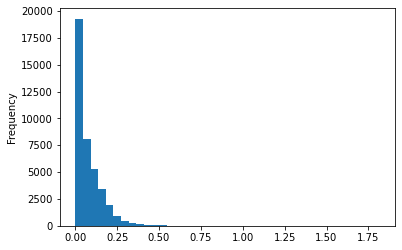

In [27]:
#Результат на kaggle 0.1264
data.query('sample == 1')['y_pred_v0_err'].plot(kind = 'hist', bins = 40)
submission_to_csv(data, subm_ID = "Restaurant_id", round_me = "round", round_coef = 2.0, y_res_name = "y_pred_v0", 
                   sub_file = "submission.csv", subm_ID_text = "Restaurant_id", subm_y_text = "Rating")

-metrics: mae -test: 0.129 -train: 0.009 -train+test: 0.027


<Figure size 432x288 with 0 Axes>

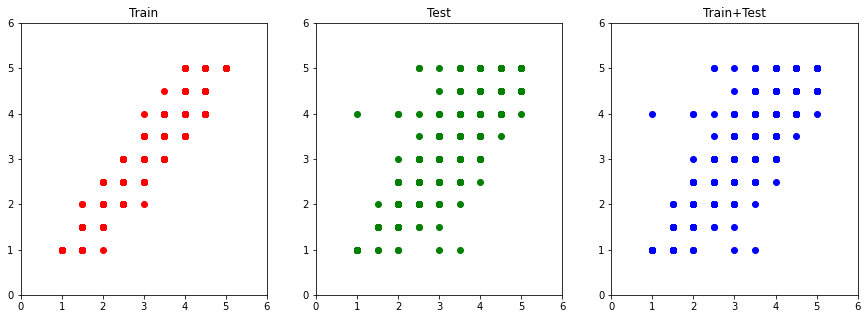

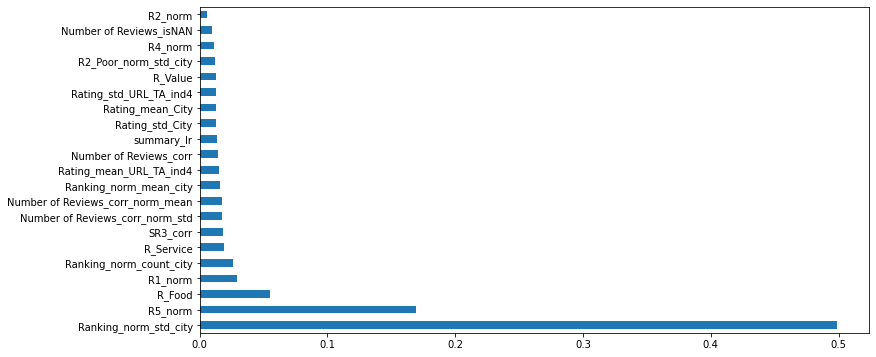

In [28]:
#---------------------------ОБУЧЕНИЕ-----RandomForestRegressor-------------------------------------------------
col_data = ['data_ind', 'Ranking_norm_std_city', 'R5_norm', 'R_Food', 'R1_norm', 'Ranking_norm_count_city', 'R_Service', 
            'Rating_mean_URL_TA_ind4', 'Number of Reviews_corr_norm_std', 'Number of Reviews_corr_norm_mean', 'R_Value', 
            'Rating_mean_City', 'Number of Reviews_isNAN', 'Number of Reviews_corr', 'Rating_std_URL_TA_ind4', 
            'Rating_std_City', 'Ranking_norm_mean_city', 'SR3_corr', 'R2_Poor_norm_std_city', 'R4_norm', 
            'summary_lr', 'R2_norm']      

RANDOM_SEED = 1509
split_params = {    
    'test_size': 0.15,
}

other_params = {
    'y_train_name': "Rating", 
    'y_res_name': "y_pred_v0",  
    'metrics_estimate' : "mae", 
    'round_me': "round", 
    'round_coef':2.0,      
    'plot_me': True,
    'xlim' : (0, 6),
    'ylim' : (0, 6),
    'feat_imp': 25,    
}

   
model = RandomForestRegressor(n_estimators = 100, verbose = 0, n_jobs = -1, random_state = RANDOM_SEED)
arranged_col = calc_dtree(model = model, split_params = split_params, cv_params = {}, **other_params)